# 0 SETUP

In [3]:
library(here)
setwd(here())
print(getwd())
source(file="misc_functions.R")
library(lattice)

here() starts at /home/sapristi/Documents/ML


[1] "/home/sapristi/Documents/ML"


In [4]:
train.raw <- read.csv("datasets/titanic_na/train.csv")
train.raw$Survived <- as.factor(train.raw$Survived)
cols.notna <- !is.na(train.raw$Age)
train.notna <- train.raw[cols.notna,]

# 1 Age exploration

## 1.0  Feature creation

We create some rows to approximate age at different resolutions

In [14]:
train.notna$Age.discf1 <- as.factor(sapply(train.notna$Age, function(age){return(as.integer(age / 1))}))
train.notna$Age.discf2 <- as.factor(sapply(train.notna$Age, function(age){return(as.integer(age / 2))}))
train.notna$Age.discf4 <- as.factor(sapply(train.notna$Age, function(age){return(as.integer(age / 4))}))

train.notna$Age.disc1 <- sapply(train.notna$Age, function(age){return(as.integer(age / 1))})
train.notna$Age.disc2 <- sapply(train.notna$Age, function(age){return(as.integer(age / 2))})
train.notna$Age.disc4 <- sapply(train.notna$Age, function(age){return(as.integer(age / 4))})

options(repr.plot.width=12)


## 1.1 Density plots : Age | Survived + Sex
Conditional density plot, not very good because we don't see the plot are on a relative scale 

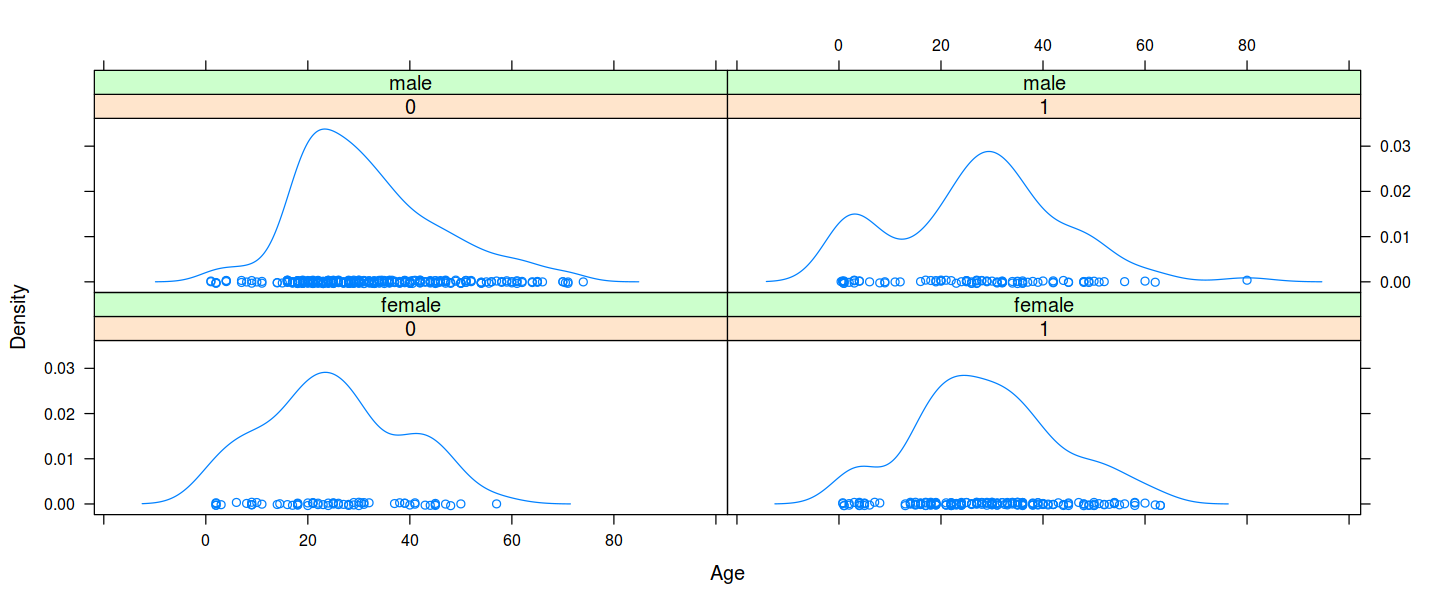

In [15]:
densityplot(~Age| Survived + Sex, data = train.notna)

## 1.2 Histogram plots : Age | Survived + Sex¶

Now this is better, since we can see the count for each age.

We can clealy see some patterns, as well as what we can think of as noise.

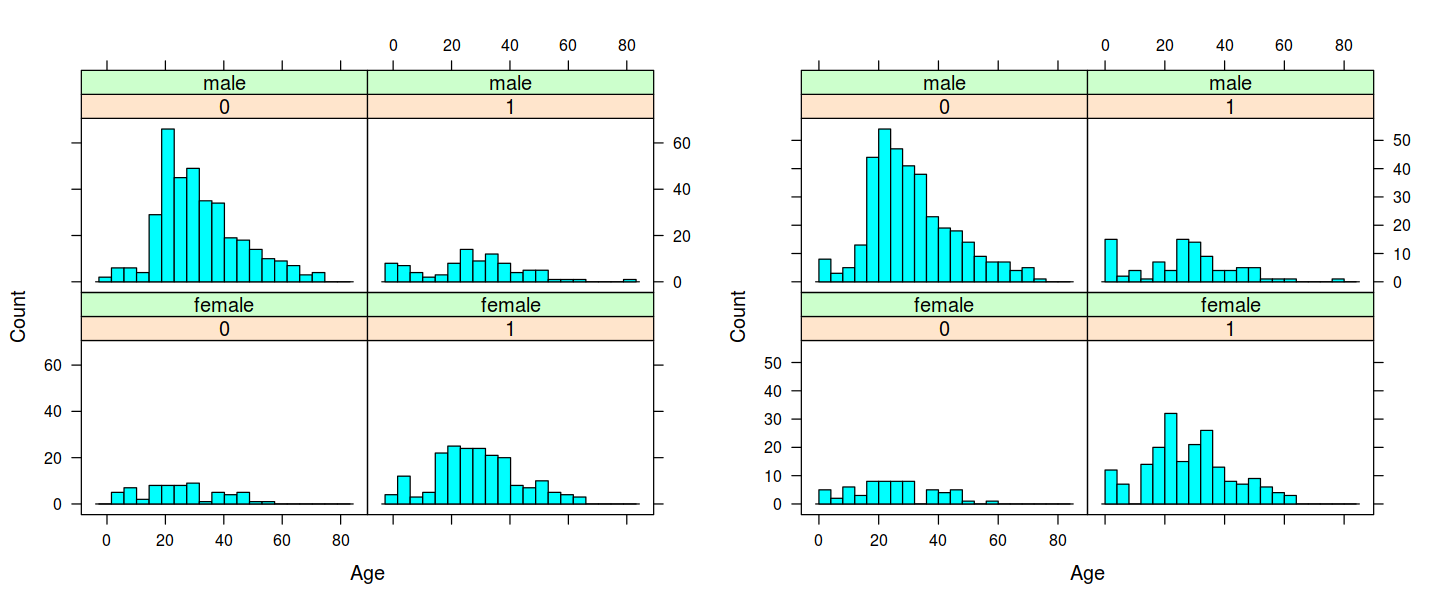

In [16]:
h1 <- histogram(~Age| Survived + Sex, data = train.notna, type="count", nint=20)
h2 <- histogram(~Age|Survived + Sex, data = train.notna, type="count", breaks = seq(from=0, to=85, by=4))

#misc_funs$multiplot(h1, h2, cols=2)
options(repr.plot.height= 5)
print(h1, split=c(1,1,2,1), more=TRUE)
print(h2, split=c(2,1,2,1))

## 1.3 Histogram : Survived | Age + Sex

This is quite good as well to see some patterns.

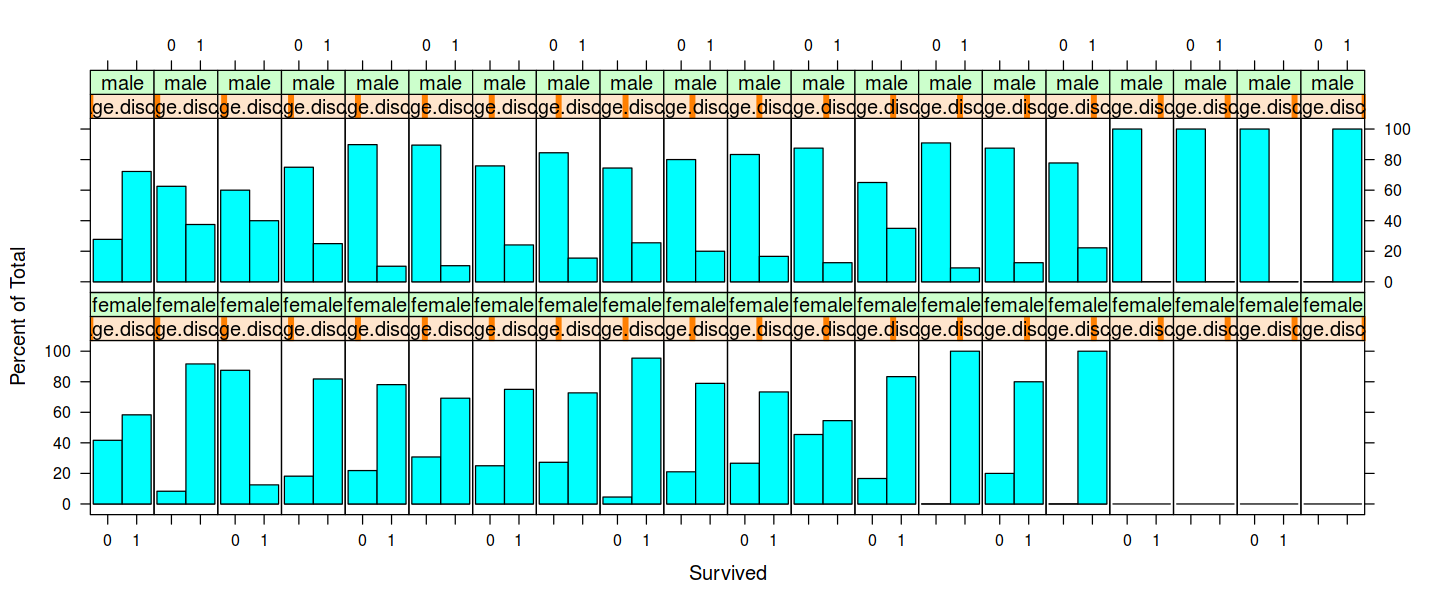

In [17]:
histogram(~Survived | Age.disc4 + Sex , data = train.notna)

From this low-res view, we can group males in 3 categories : 

  - less than 12 : can be saved
  - between 12 and 60 : likely to die
  - more than 60 : will surely die (except from a lone old man ?)
  
For females there is a strange death-surge between 8 and 12 yo, and there is no very clear pattern, except that old females tend to survive quite well.

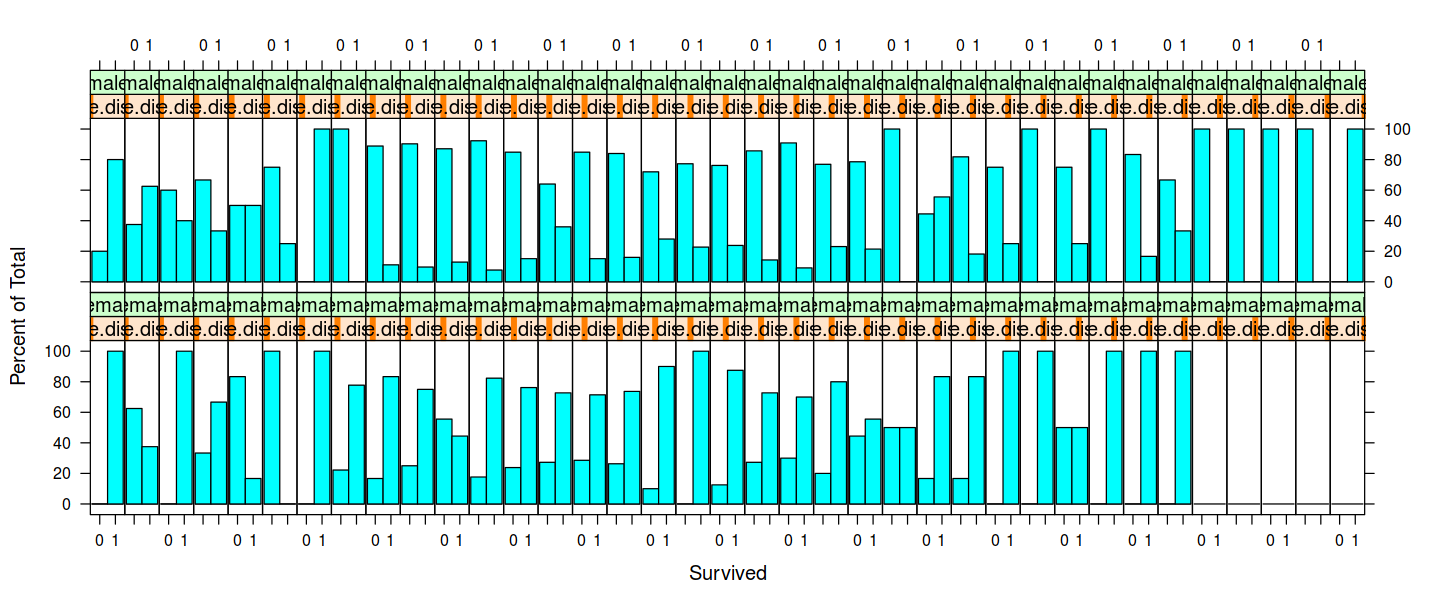

In [18]:
histogram(~Survived | Age.disc2 + Sex , data = train.notna)

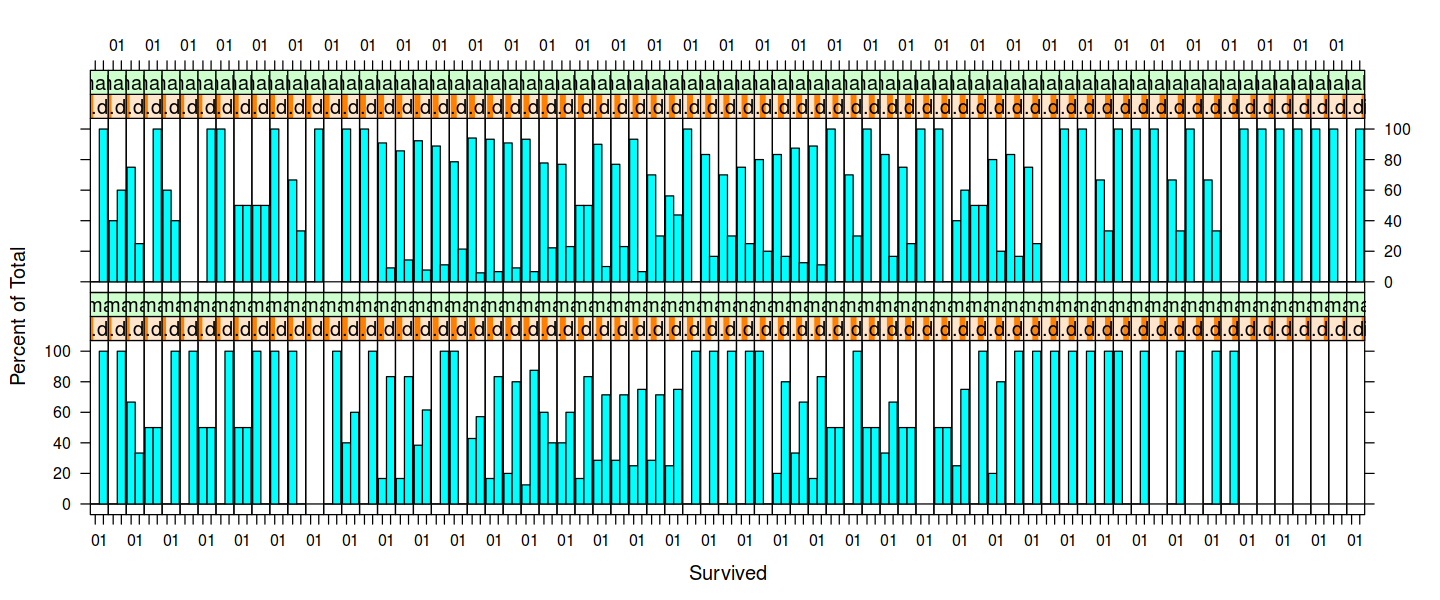

In [19]:
histogram(~Survived | Age.disc1 + Sex , data = train.notna)

## 1.4 Histgram : zooming in

Too much data, lets try to zoom in. We also use `count` histogram type, and can see how little data there is for children.
A good limit for both boys and girls seems to be 15 y.o.

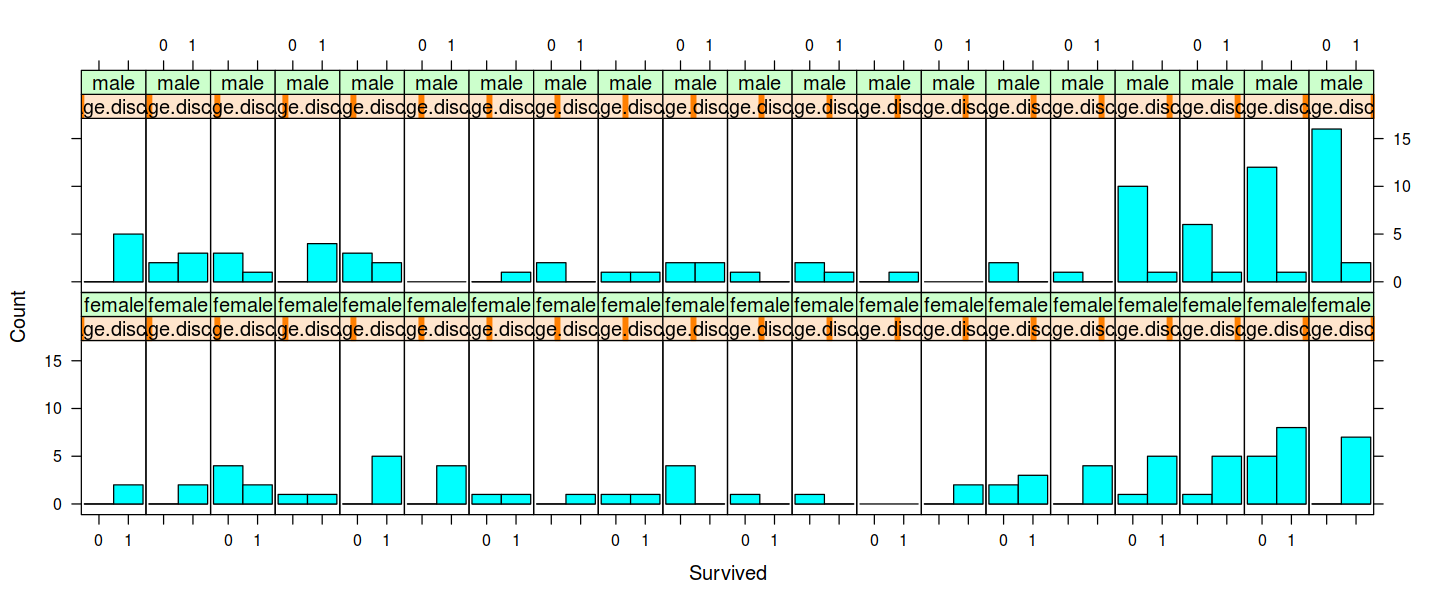

In [20]:
histogram(~Survived | Age.disc1 + Sex , data = train.notna[train.notna$Age.disc1 < 20,], type = "count")

Let's see what happens between 40 and 60 :

We can see a limit for both males and females at about 51 y.o

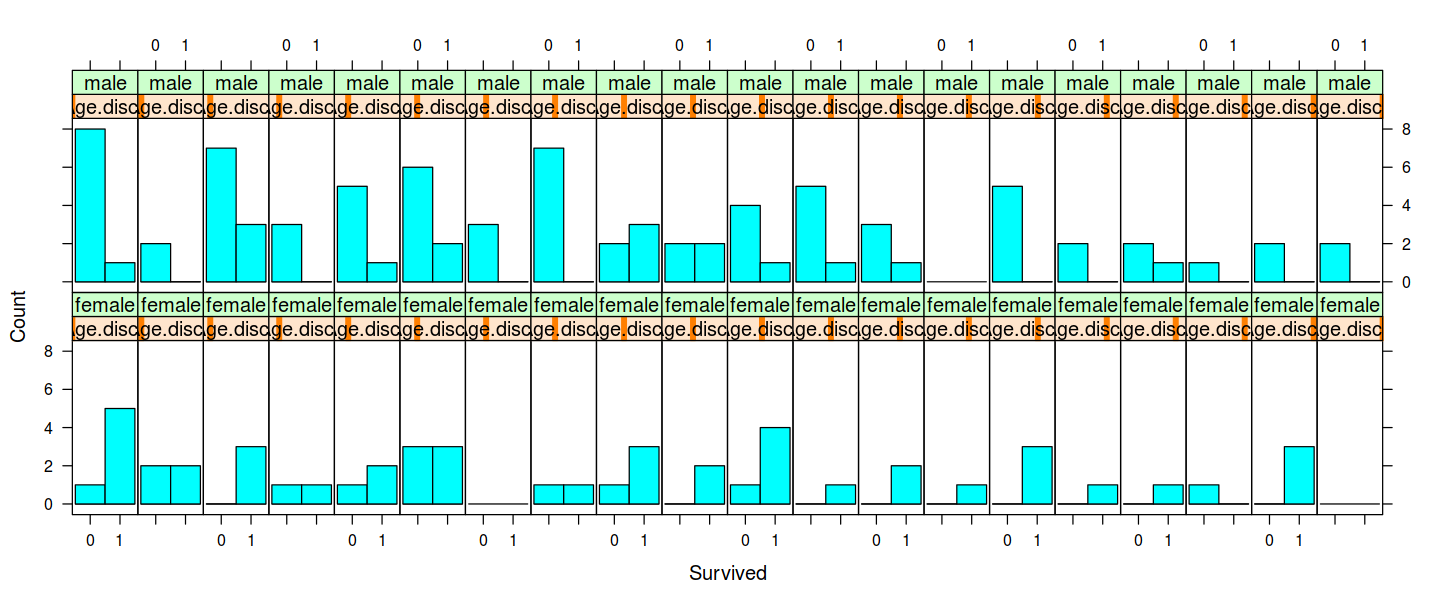

In [21]:
histogram(~Survived | Age.disc1 + Sex , 
          data = train.notna[train.notna$Age.disc1 >= 40 & train.notna$Age.disc1 < 60,], 
          type = "count")

## 1.5 Conclusion

From what we could see, wa can modify the features in the following way : 
 
  - set Age as an integer, and round < 0 to 1
  - create a feature Age.simple that separates between =< 15, 15 < 51 and > 51
  - create a feature Age.disc with age at resolution 4 or 5

# 2 Age imputation

We need to fill in missing age values. Lets first load training data, the features we forged and select the data with Non NA so that we can have an idea of how it looks : 

In [23]:
library(here)
setwd(here())
source(file="misc_functions.R")
source("experiments/titanic_challenge/1_feature_engineering.R")
library(mice)
library(lattice)

train.raw <- read.csv("datasets/titanic_na/train.csv")
train.ff <- fe$forge_features(train.raw)


cols.notna <- !is.na(train.raw$Age)
train.notna <- train.raw[cols.notna,]
train.notna$Title <- train.ff$Title[cols.notna]
train.notna$Age <- train.ff$Age[cols.notna]
train.notna$Age.simple <- train.ff$Age.simple[cols.notna]
train.notna$Age.disc5 <- train.ff$Age.disc5[cols.notna]



Attaching package: ‘mice’

The following objects are masked from ‘package:base’:

    cbind, rbind



We will then display different graphs to see how age distribute according to other variables. The biggest hint is from the forged Title variable.

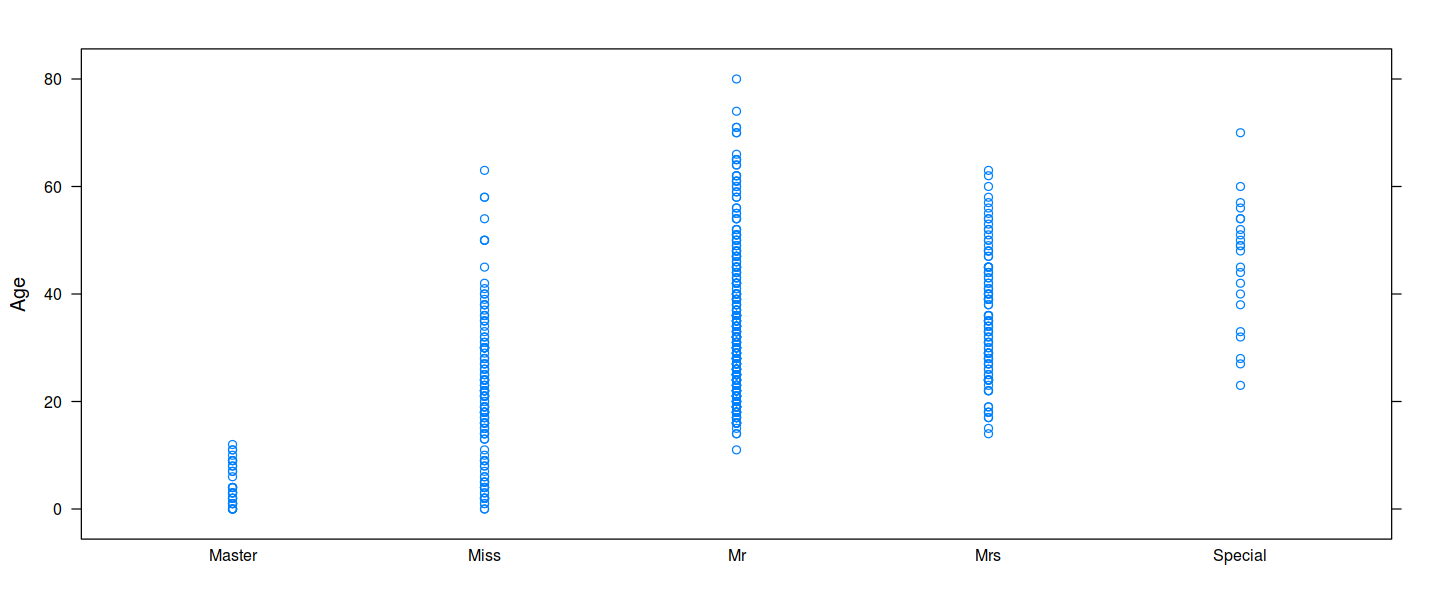

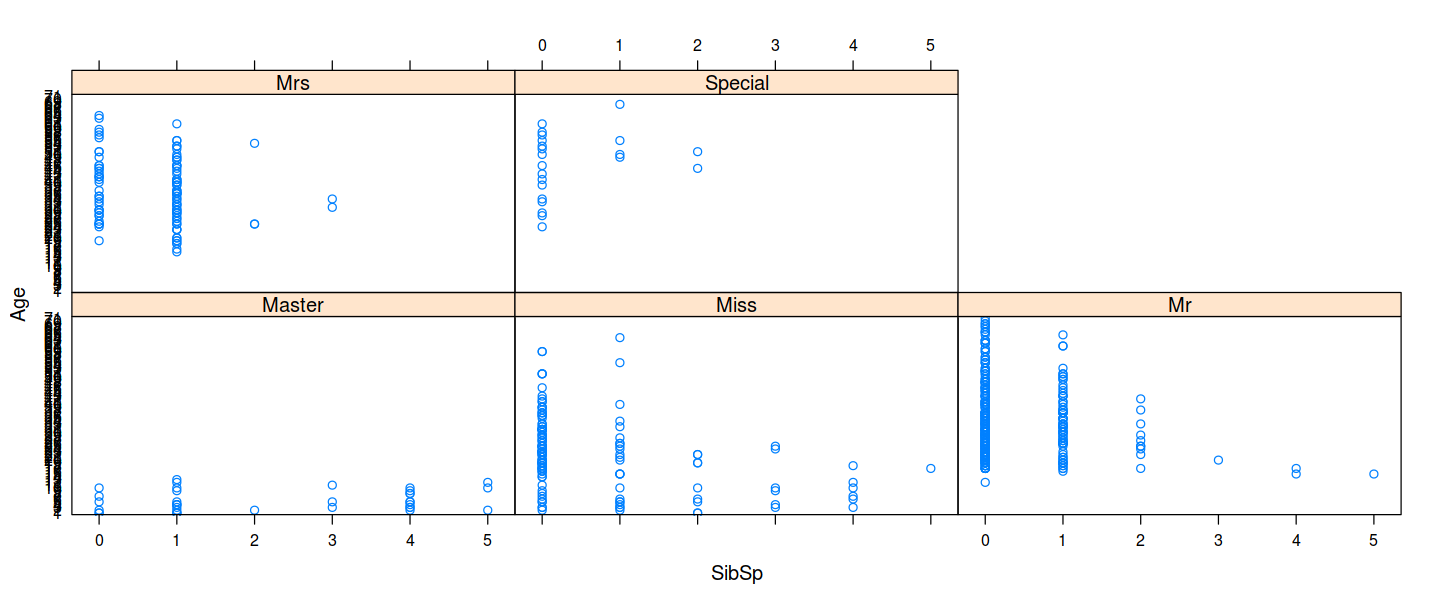

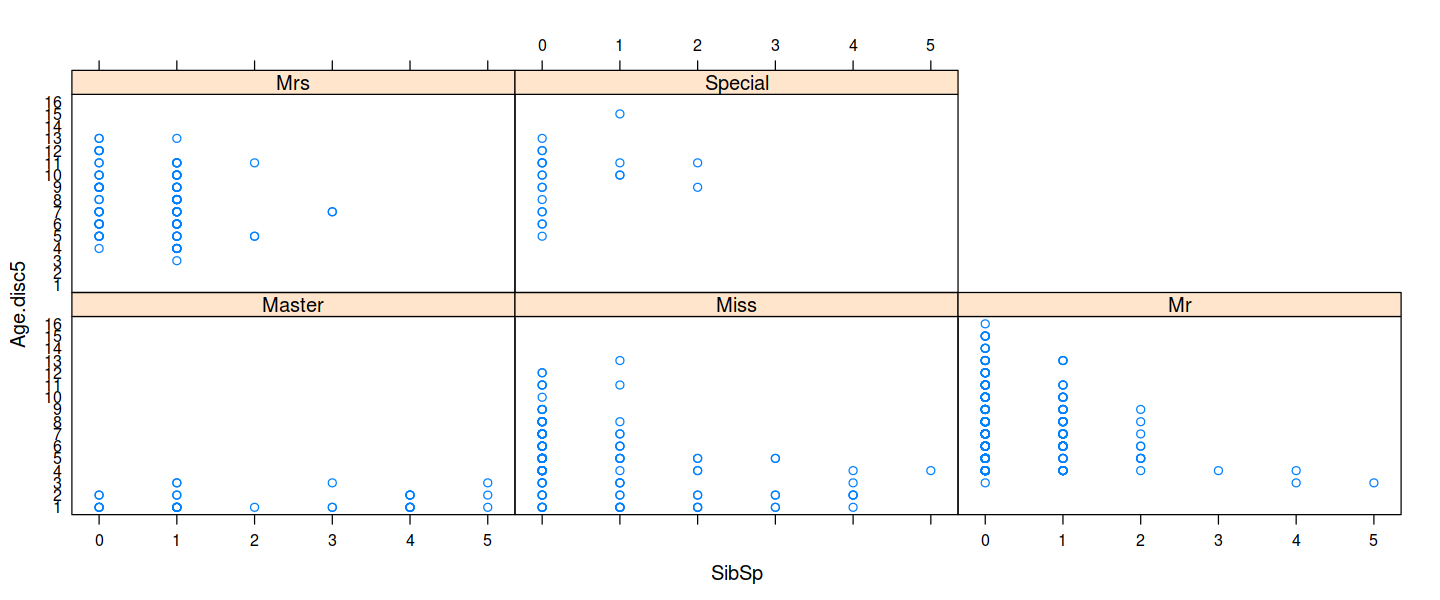

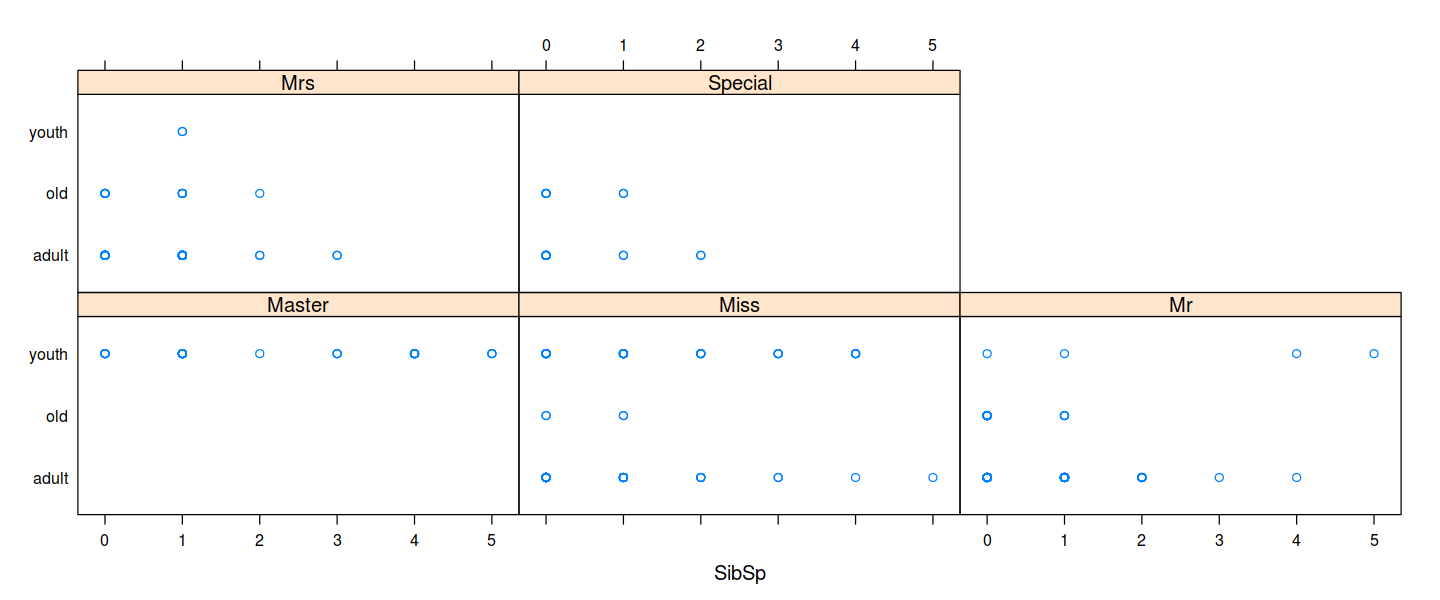

In [24]:
stripplot(Age ~ Title, data = train.notna)
stripplot(Age ~ SibSp | Title, data = train.notna)
stripplot(Age.disc5 ~ SibSp | Title, data = train.notna)
stripplot(Age.simple ~ SibSp | Title, data = train.notna)

## 2.1 Imputation to normal age

We will impute data for the Age feature


In [18]:
train.mice <- data.frame(train.raw)
train.mice$Title <- train.ff$Title
train.mice$Age <- train.ff$Age
#train.mice$Age.simple <- train.ff$Age.simple
#train.mice$Age.disc5 <- train.ff$Age.disc5

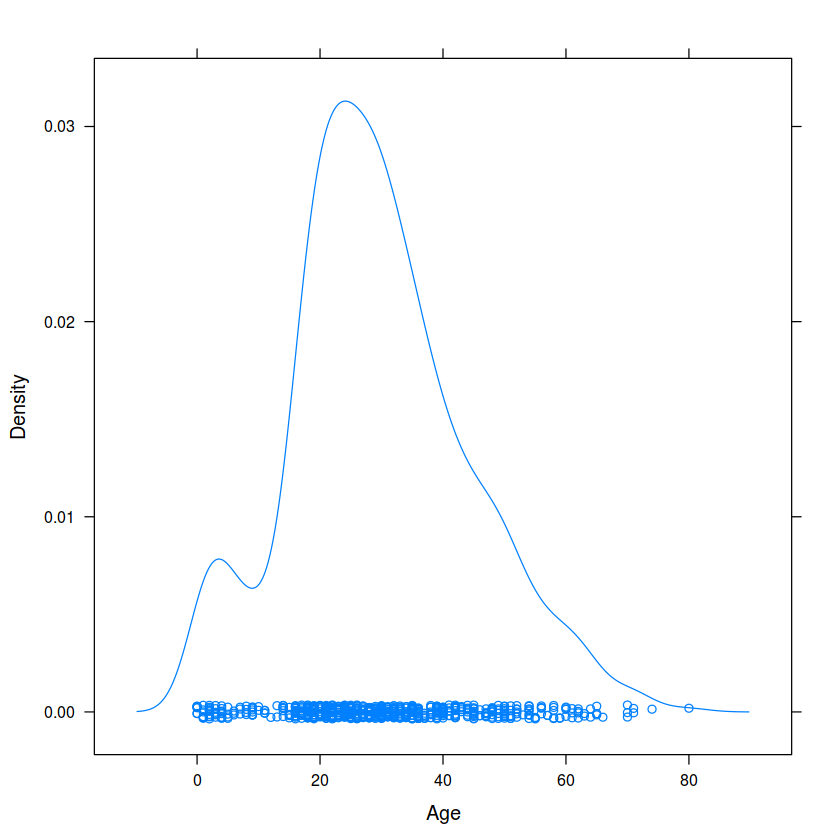

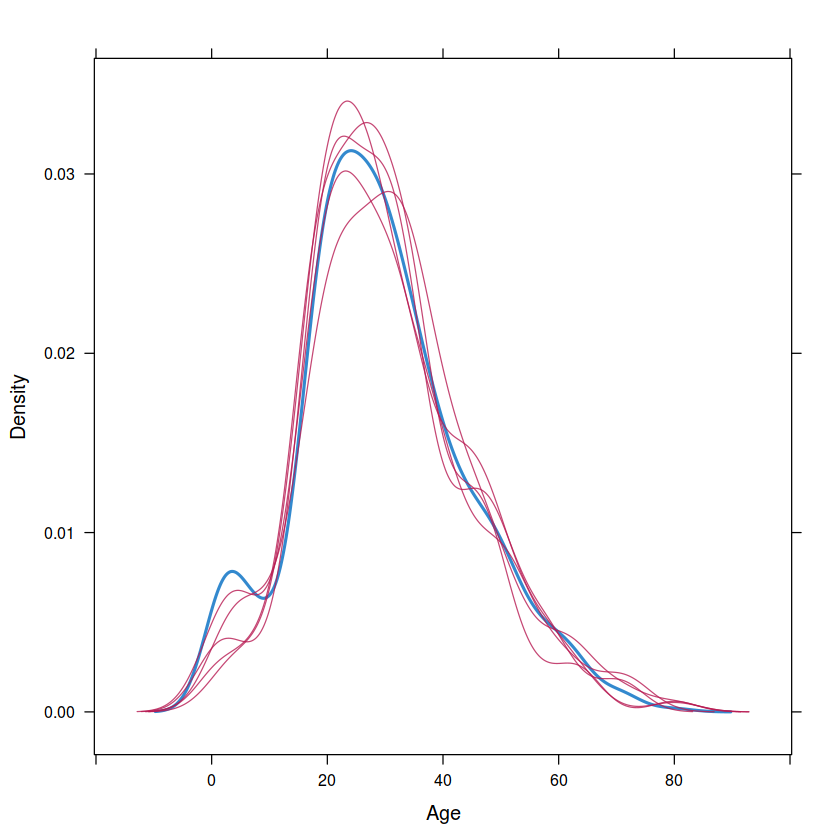

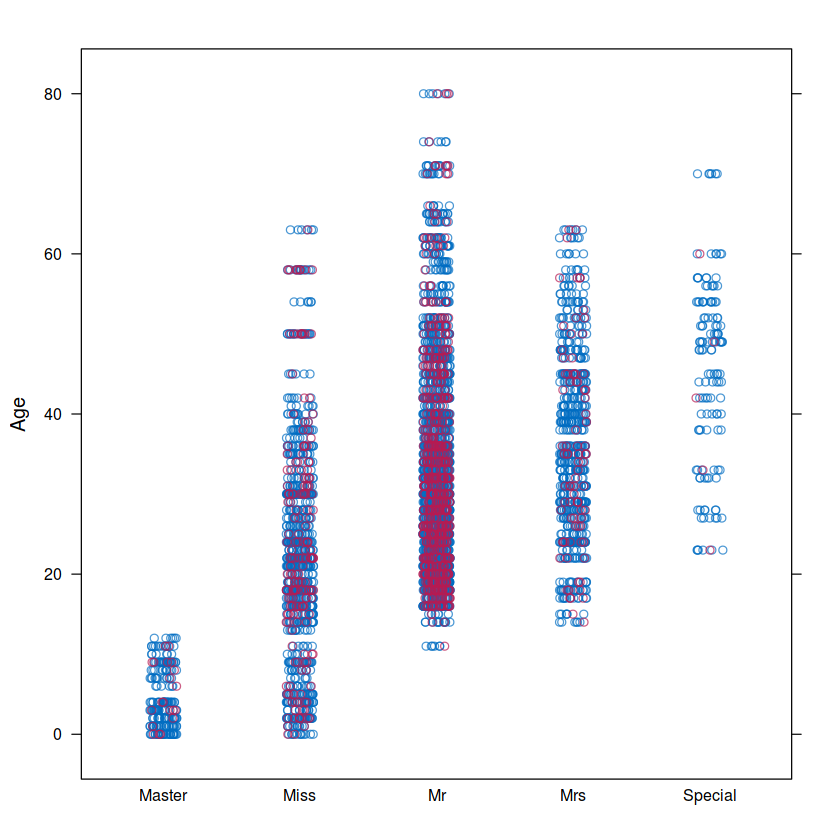

In [21]:
imp1.cart <- mice(train.mice, m=5, method='cart', printFlag = FALSE, formulas = list(Age = Age ~ Title))
densityplot(~Age, data= train.notna)
densityplot(imp1.cart)
stripplot(imp1.cart, Age ~ Title)

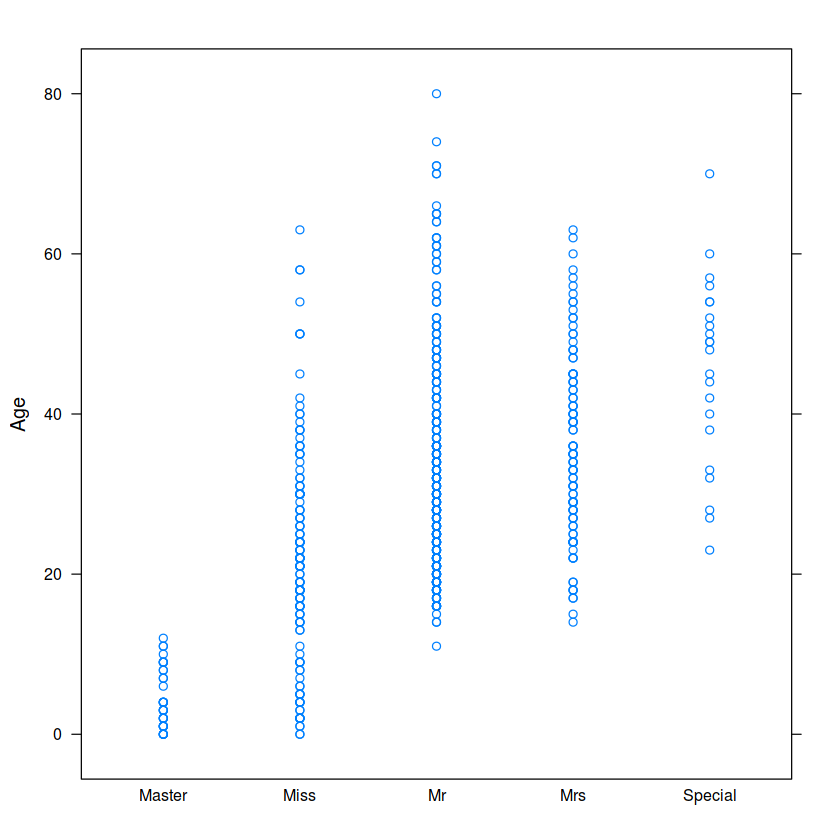

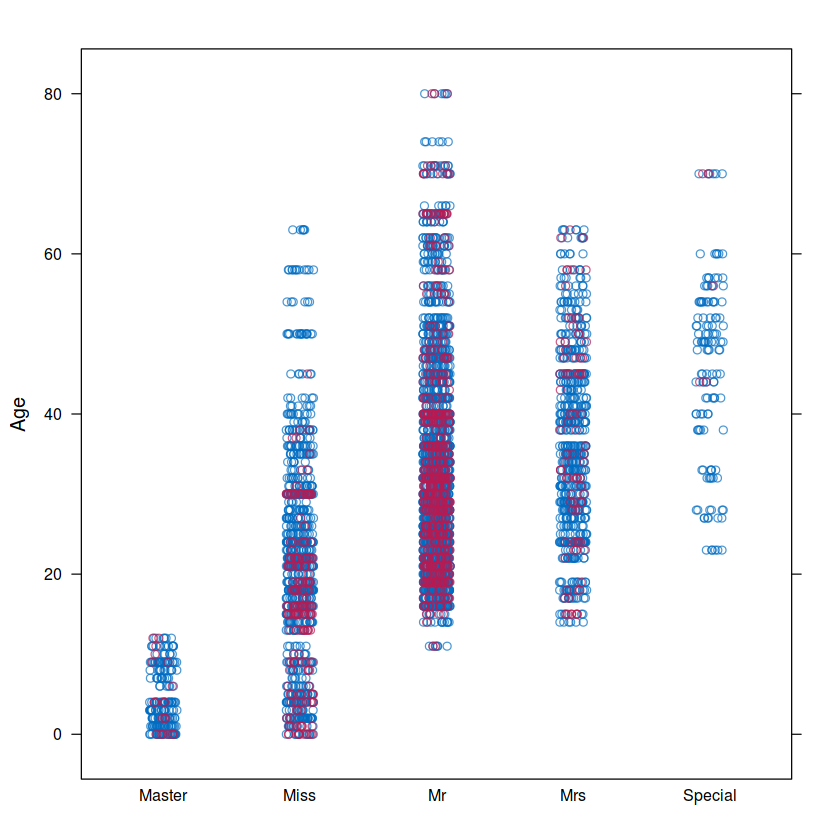

In [24]:
imp1.cart <- mice(train.mice, m=5, method='cart', printFlag = FALSE, formulas = list(Age = Age ~ Title + Fare + Embarked))
stripplot(data = train.mice, Age ~ Title)
stripplot(imp1.cart, Age ~ Title)